
<a id='ifp'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Optimal Savings III: Occasionally Binding Constraints

## Colab Instructions

Colab does not have direct Julia support, and it must be installed each time you are working on a notebook.  

Instructions:

1. Ignore any errors about a missing kernel when loading the notebook.  Choose `Run Anyway` when it prompts that the notebook wasn't authored by google.

2. Run the cell below this with `Shift+Enter`.
    -  It will **5 to 8 minutes** the first time you run it for Julia and key packages to install

3. Refresh your browser, and then execute any code as normal.
  - Even after installation, there will be more precompiling latency for some packages. 

In [ ]:
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
    julia -e 'using Pkg; pkg"add IJulia InstantiateFromURL; precompile;"'
    julia -e 'using InstantiateFromURL; github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0", instantiate = true, precompile = false); using Plots, Distributions, Parameters, NLsolve, ForwardDiff, Expectations'
    echo 'Done'
fi


## Contents

- [Optimal Savings III: Occasionally Binding Constraints](#Optimal-Savings-III:-Occasionally-Binding-Constraints)  
  - [Overview](#Overview)  
  - [The Optimal Savings Problem](#The-Optimal-Savings-Problem)  
  - [Computation](#Computation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

Next we study an optimal savings problem for an infinitely lived consumer—the “common ancestor” described in [[LS18]](../zreferences.html#ljungqvist2012), section 1.3.

This is an essential sub-problem for many representative macroeconomic models

- [[Aiy94]](../zreferences.html#aiyagari1994)  
- [[Hug93]](../zreferences.html#huggett1993)  
- etc.  


It is related to the decision problem in the [stochastic optimal growth
model](optgrowth.html) and yet differs in important ways.

For example, the choice problem for the agent includes an additive income term that leads to an occasionally binding constraint.

Our presentation of the model will be relatively brief.

- For further details on economic intuition, implication and models, see [[LS18]](../zreferences.html#ljungqvist2012)  
- Proofs of all mathematical results stated below can be found in <a href=/_static/pdfs/pi2.pdf download>this paper</a>  


To solve the model we will use Euler equation based time iteration, similar to [this lecture](coleman_policy_iter.html).

This method turns out to be

- Globally convergent under mild assumptions, even when utility is unbounded (both above and below).  
- More efficient numerically than value function iteration.  

### References

Other useful references include [[Dea91]](../zreferences.html#deaton1991), [[DH10]](../zreferences.html#denhaan2010), [[Kuh13]](../zreferences.html#kuhn2013), [[Rab02]](../zreferences.html#rabault2002),  [[Rei09]](../zreferences.html#reiter2009)  and [[SE77]](../zreferences.html#schechtmanescudero1977).

## The Optimal Savings Problem


<a id='index-1'></a>
Let’s write down the model and then discuss how to solve it.

### Set Up

Consider a household that chooses a state-contingent consumption plan $ \{c_t\}_{t \geq 0} $ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to


<a id='equation-eqst'></a>
$$
c_t + a_{t+1} \leq  Ra_t  + z_t,
\qquad c_t \geq 0,
\qquad a_t \geq -b
\qquad t = 0, 1, \ldots \tag{1}
$$

Here

- $ \beta \in (0,1) $ is the discount factor  
- $ a_t $ is asset holdings at time $ t $, with ad-hoc borrowing constraint $ a_t \geq -b $  
- $ c_t $ is consumption  
- $ z_t $ is non-capital income (wages, unemployment compensation, etc.)  
- $ R := 1 + r $, where $ r > 0 $ is the interest rate on savings  


Non-capital income $ \{z_t\} $ is assumed to be a Markov process taking values in $ Z\subset (0,\infty) $ with stochastic kernel $ \Pi $.

This means that $ \Pi(z, B) $ is the probability that $ z_{t+1} \in
B $ given $ z_t = z $.

The expectation of $ f(z_{t+1}) $ given $ z_t = z $ is written as

$$
\int f( \acute z) \, \Pi(z, d \acute z)
$$

We further assume that

1. $ r > 0 $ and $ \beta R < 1 $  
1. $ u $ is smooth, strictly increasing and strictly concave with $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  


The asset space is $ [-b, \infty) $ and the state is the pair $ (a,z) \in S := [-b,\infty) \times Z $.

A *feasible consumption path* from $ (a,z) \in S $ is a consumption
sequence $ \{c_t\} $ such that $ \{c_t\} $ and its induced asset path $ \{a_t\} $ satisfy

1. $ (a_0, z_0) = (a, z) $  
1. the feasibility constraints in [(1)](#equation-eqst), and  
1. measurability of $ c_t $ w.r.t. the filtration generated by $ \{z_1, \ldots, z_t\} $  


The meaning of the third point is just that consumption at time $ t $ can only be
a function of outcomes that have already been observed.

### Value Function and Euler Equation

The *value function* $ V \colon S \to \mathbb{R} $ is defined by


<a id='equation-eqvf'></a>
$$
V(a, z) := \sup \, \mathbb{E}
\left\{
\sum_{t=0}^{\infty} \beta^t u(c_t)
\right\} \tag{2}
$$

where the supremum is over all feasible consumption paths from $ (a,z) $.

An *optimal consumption path* from $ (a,z) $ is a feasible consumption path from $ (a,z) $ that attains the supremum in [(2)](#equation-eqvf).

To pin down such paths we can use a version of the Euler equation, which in the present setting is


<a id='equation-ee00'></a>
$$
u' (c_t)
\geq \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] \tag{3}
$$

and


<a id='equation-ee01'></a>
$$
u' (c_t) = \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ]
\quad \text{whenever }
c_t < Ra_t + z_t + b \tag{4}
$$

In essence, this says that the natural “arbitrage” relation $ u' (c_t) = \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] $ holds when the choice of current consumption is interior.

Interiority means that $ c_t $ is strictly less than its upper bound $ Ra_t + z_t + b $.

(The lower boundary case $ c_t = 0 $ never arises at the optimum because
$ u'(0) = \infty $)

When $ c_t $ does hit the upper bound $ Ra_t + z_t + b $, the
strict inequality $ u' (c_t) > \beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] $
can occur because $ c_t $ cannot increase sufficiently to attain equality.

With some thought and effort, one can show that [(3)](#equation-ee00) and [(4)](#equation-ee01) are
equivalent to


<a id='equation-eqeul0'></a>
$$
u' (c_t)
= \max \left\{
\beta R \,  \mathbb{E}_t [ u'(c_{t+1}) ] \,,\;  u'(Ra_t + z_t + b)
\right\} \tag{5}
$$

### Optimality Results

Given our assumptions, it is <a href=/_static/pdfs/pi2.pdf download>known</a> that

1. For each $ (a,z) \in S $, a unique optimal consumption path from $ (a,z) $ exists.  
1. This path is the unique feasible path from $ (a,z) $ satisfying the
  Euler equality [(5)](#equation-eqeul0) and the transversality condition  



<a id='equation-eqtv'></a>
$$
\lim_{t \to \infty} \beta^t \, \mathbb{E} \, [ u'(c_t) a_{t+1} ] = 0. \tag{6}
$$

Moreover, there exists an *optimal consumption function* $ c^* \colon S \to [0, \infty) $ such that the path from $ (a,z) $ generated by

$$
(a_0, z_0) = (a, z),
\quad
z_{t+1} \sim \Pi(z_t, dy),
\quad
c_t = c^*(a_t, z_t)
\quad \text{and} \quad
a_{t+1} = R a_t + z_t - c_t
$$

satisfies both [(5)](#equation-eqeul0) and [(6)](#equation-eqtv), and hence is the unique optimal
path from $ (a,z) $.

In summary, to solve the optimization problem, we need to compute $ c^* $.


<a id='ifp-computation'></a>

## Computation


<a id='index-2'></a>
There are two standard ways to solve for $ c^* $

1. Time iteration (TI) using the Euler equality  
1. Value function iteration (VFI)  


Let’s look at these in turn.

### Time Iteration

We can rewrite [(5)](#equation-eqeul0) to make it a statement about functions rather than
random variables.

In particular, consider the functional equation


<a id='equation-eqeul1'></a>
$$
u' \circ c \, (a, z)
= \max \left\{
\gamma \int u' \circ c \, \{R a + z - c(a, z), \, \acute z\}
\, \Pi(z,d \acute z)
\, , \;
     u'(Ra + z + b)
     \right\} \tag{7}
$$

where $ \gamma := \beta R $ and $ u' \circ c(s) := u'(c(s)) $.

Equation [(7)](#equation-eqeul1) is a functional equation in $ c $.

In order to identify a solution, let $ \mathscr{C} $ be the set of candidate consumption functions $ c \colon S \to \mathbb R $ such that

- each $ c \in \mathscr{C} $ is continuous and (weakly) increasing  
- $ \min Z \leq c(a,z) \leq Ra + z + b $ for all $ (a,z) \in S $  


In addition, let $ K \colon \mathscr{C} \to \mathscr{C} $ be defined as follows:

For given $ c\in \mathscr{C} $, the value $ Kc(a,z) $ is the unique $ t \in J(a,z) $ that solves


<a id='equation-eqsifc'></a>
$$
u'(t)
= \max \left\{
\gamma \int u' \circ c \, \{R a + z - t, \, \acute z\}
\, \Pi(z,d \acute z)
\, , \;
     u'(Ra + z + b)
     \right\} \tag{8}
$$

where


<a id='equation-eqbos'></a>
$$
J(a,z) := \{t \in \mathbb{R} \,:\, \min Z \leq t \leq Ra+ z + b\} \tag{9}
$$

We refer to $ K $ as Coleman’s policy function operator [[Col90]](../zreferences.html#coleman1990).

It is <a href=/_static/pdfs/pi2.pdf download>known</a> that

- $ K $ is a contraction mapping on $ \mathscr{C} $ under the metric  


$$
\rho(c, d) := \| \, u' \circ c - u' \circ d \, \|
    := \sup_{s \in S} | \, u'(c(s))  - u'(d(s)) \, |
 \qquad \quad (c, d \in \mathscr{C})
$$

- The metric $ \rho $ is complete on $ \mathscr{C} $  
- Convergence in $ \rho $ implies uniform convergence on compacts  


In consequence, $ K $ has a unique fixed point $ c^* \in \mathscr{C} $
and $ K^n c \to c^* $ as $ n \to \infty $ for any $ c \in \mathscr{C} $.

By the definition of $ K $, the fixed points of $ K $ in $ \mathscr{C} $ coincide with
the solutions to [(7)](#equation-eqeul1) in $ \mathscr{C} $.

In particular, it <a href=/_static/pdfs/pi2.pdf download>can be shown</a> that the path $ \{c_t\} $
generated from $ (a_0,z_0) \in S $ using policy function $ c^* $ is
the unique optimal path from $ (a_0,z_0) \in S $.

**TL;DR** The unique optimal policy can be computed by picking any
$ c \in \mathscr{C} $ and iterating with the operator $ K $ defined in [(8)](#equation-eqsifc).

### Value Function Iteration

The Bellman operator for this problem is given by


<a id='equation-eqbop'></a>
$$
Tv(a, z)
= \max_{0 \leq c \leq Ra + z + b}
\left\{
    u(c) + \beta \int v(Ra + z - c, \acute z) \Pi(z, d \acute z)
\right\} \tag{10}
$$

We have to be careful with VFI (i.e., iterating with
$ T $) in this setting because $ u $ is not assumed to be bounded

- In fact typically unbounded both above and below — e.g. $ u(c) = \log c $.  
- In which case, the standard DP theory does not apply.  
- $ T^n v $ is not guaranteed to converge to the value function for arbitrary continous bounded $ v $.  


Nonetheless, we can always try the popular strategy “iterate and hope”.

We can then check the outcome by comparing with that produced by TI.

The latter is known to converge, as described above.

### Implementation


<a id='index-3'></a>
Here’s the code for a named-tuple constructor called `ConsumerProblem` that stores primitives, as well as

- a `T` function, which implements the Bellman operator $ T $ specified above  
- a `K` function, which implements the Coleman operator $ K $ specified above  
- an `initialize`, which generates suitable initial conditions for iteration  

### Setup

In [1]:
using InstantiateFromURL
# optionally add arguments to force installation: instantiate = true, precompile = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.7.0")

In [2]:
using LinearAlgebra, Statistics
using BenchmarkTools, Optim, Parameters, Plots, QuantEcon, Random
using Optim: converged, maximum, maximizer, minimizer, iterations
gr(fmt = :png);

In [3]:
# utility and marginal utility functions
u(x) = log(x)
du(x) = 1 / x

# model
function ConsumerProblem(;r = 0.01,
                         β = 0.96,
                         Π = [0.6 0.4; 0.05 0.95],
                         z_vals = [0.5, 1.0],
                         b = 0.0,
                         grid_max = 16,
                         grid_size = 50)
    R = 1 + r
    asset_grid = range(-b, grid_max, length = grid_size)

    return (r = r, R = R, β = β, b = b, Π = Π, z_vals = z_vals, asset_grid = asset_grid)
end

function T!(cp, V, out; ret_policy = false)

    # unpack input, set up arrays
    @unpack R, Π, β, b, asset_grid, z_vals = cp
    z_idx = 1:length(z_vals)

    # value function when the shock index is z_i
    vf = interp(asset_grid, V)

    opt_lb = 1e-8

    # solve for RHS of Bellman equation
    for (i_z, z) in enumerate(z_vals)
        for (i_a, a) in enumerate(asset_grid)

            function obj(c)
                EV = dot(vf.(R * a + z - c, z_idx), Π[i_z, :]) # compute expectation
                return u(c) +  β * EV
            end
            res = maximize(obj, opt_lb, R .* a .+ z .+ b)
            converged(res) || error("Didn't converge") # important to check

            if ret_policy
                out[i_a, i_z] = maximizer(res)
            else
                out[i_a, i_z] = maximum(res)
            end

        end
    end
    out
end

T(cp, V; ret_policy = false) =
    T!(cp, V, similar(V); ret_policy = ret_policy)

get_greedy!(cp, V, out) =
    update_bellman!(cp, V, out, ret_policy = true)

get_greedy(cp, V) =
    update_bellman(cp, V, ret_policy = true)

function K!(cp, c, out)
    # simplify names, set up arrays
    @unpack R, Π, β, b, asset_grid, z_vals = cp
    z_idx = 1:length(z_vals)
    gam = R * β

    # policy function when the shock index is z_i
    cf = interp(asset_grid, c)

    # compute lower_bound for optimization
    opt_lb = 1e-8

    for (i_z, z) in enumerate(z_vals)
        for (i_a, a) in enumerate(asset_grid)
            function h(t)
                cps = cf.(R * a + z - t, z_idx) # c' for each z'
                expectation = dot(du.(cps), Π[i_z, :])
                return abs(du(t) - max(gam * expectation, du(R * a + z + b)))
            end
            opt_ub = R*a + z + b  # addresses issue #8 on github
            res = optimize(h, min(opt_lb, opt_ub - 1e-2), opt_ub,
                           method = Optim.Brent())
            out[i_a, i_z] = minimizer(res)
        end
    end
    return out
end

K(cp, c) = K!(cp, c, similar(c))

function initialize(cp)
    # simplify names, set up arrays
    @unpack R, β, b, asset_grid, z_vals = cp
    shape = length(asset_grid), length(z_vals)
    V, c = zeros(shape...), zeros(shape...)

    # populate V and c
    for (i_z, z) in enumerate(z_vals)
        for (i_a, a) in enumerate(asset_grid)
            c_max = R * a + z + b
            c[i_a, i_z] = c_max
            V[i_a, i_z] = u(c_max) / (1 - β)
        end
    end

    return V, c
end

initialize (generic function with 1 method)

Both `T` and `K` use linear interpolation along the asset grid to approximate the value and consumption functions.

The following exercises walk you through several applications where policy functions are computed.

In exercise 1 you will see that while VFI and TI produce similar results, the latter is much faster.

Intuition behind this fact was provided in [a previous lecture on time iteration](coleman_policy_iter.html).

## Exercises


<a id='ifp-ex1'></a>

### Exercise 1

The first exercise is to replicate the following figure, which compares TI and VFI as solution methods

<img src="_static/figures/vfi_vs_pfi.png" style="width:100%;">

  
The figure shows consumption policies computed by iteration of $ K $ and $ T $ respectively

- In the case of iteration with $ T $, the final value function is used to compute the observed policy.  


Consumption is shown as a function of assets with income $ z $ held fixed
at its smallest value.

The following details are needed to replicate the figure

- The parameters are the default parameters in the definition of `consumerProblem`.  
- The initial conditions are the default ones from `initialize(cp)`.  
- Both operators are iterated 80 times.  


When you run your code you will observe that iteration with $ K $ is
faster than iteration with $ T $.

In the Julia console, a comparison of the operators can be made as follows

In [4]:
cp = ConsumerProblem()
v, c, = initialize(cp)

([-17.328679513998615 0.0; -4.664387247760648 7.125637140580436; … ; 69.82541010621486 70.57937835479346; 70.32526591846735 71.06452735149534], [0.5 1.0; 0.8297959183673469 1.329795918367347; … ; 16.33020408163265 16.83020408163265; 16.66 17.16])

In [5]:
@btime T(cp, v);

  507.584 μs (4676 allocations: 428.20 KiB)


In [6]:
@btime K(cp, c);

  704.904 μs (7925 allocations: 742.17 KiB)



<a id='ifp-ex2'></a>

### Exercise 2

Next let’s consider how the interest rate affects consumption.

Reproduce the following figure, which shows (approximately) optimal consumption policies for different interest rates

<img src="_static/figures/ifp_policies.png" style="width:100%;">

  
- Other than r, all parameters are at their default values  
- r steps through range(0, 0.04, length = 4)  
- Consumption is plotted against assets for income shock fixed at the smallest value  


The figure shows that higher interest rates boost savings and hence suppress consumption.


<a id='ifp-ex3'></a>

### Exercise 3

Now let’s consider the long run asset levels held by households.

We’ll take r = 0.03 and otherwise use default parameters.

The following figure is a 45 degree diagram showing the law of motion for assets when consumption is optimal

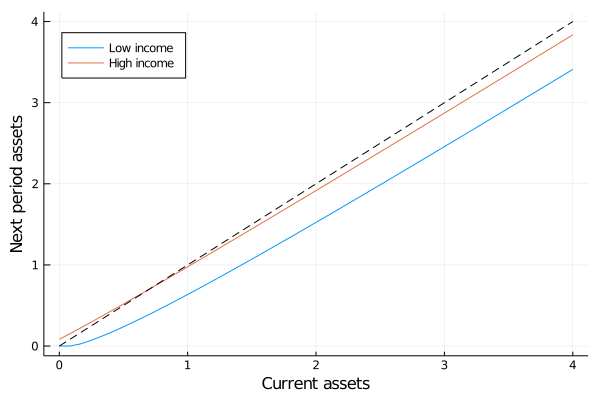

In [7]:
# solve for optimal consumption
m = ConsumerProblem(r = 0.03, grid_max = 4)
v_init, c_init = initialize(m)

c = compute_fixed_point(c -> K(m, c),
                        c_init,
                        max_iter = 150,
                        verbose = false)
a = m.asset_grid
R, z_vals = m.R, m.z_vals

# generate savings plot
plot(a, R * a .+ z_vals[1] - c[:, 1], label = "Low income")
plot!(xlabel = "Current assets", ylabel = "Next period assets")
plot!(a, R * a .+ z_vals[2] - c[:, 2], label = "High income")
plot!(xlabel = "Current assets", ylabel = "Next period assets")
plot!(a, a, linestyle = :dash, color = "black", label = "")
plot!(xlabel = "Current assets", ylabel = "Next period assets")
plot!(legend = :topleft)

The blue line and orange line represent the function

$$
a' = h(a, z) := R a + z - c^*(a, z)
$$

when income $ z $ takes its high and low values respectively.

The dashed line is the 45 degree line.

We can see from the figure that the dynamics will be stable — assets do not
diverge.

In fact there is a unique stationary distribution of assets that we can calculate by simulation

- Can be proved via theorem 2 of [[HP92]](../zreferences.html#hopenhaynprescott1992).  
- Represents the long run dispersion of assets across households when households have idiosyncratic shocks.  


Ergodicity is valid here, so stationary probabilities can be calculated by averaging over a single long time series.

- Hence to approximate the stationary distribution we can simulate a long time series for assets and histogram, as in the following figure  


<img src="_static/figures/ifp_histogram.png" style="width:100%;">

  
Your task is to replicate the figure

- Parameters are as discussed above  
- The histogram in the figure used a single time series $ \{a_t\} $ of length 500,000  
- Given the length of this time series, the initial condition $ (a_0, z_0) $ will not matter  
- You might find it helpful to use the `MarkovChain` type from `quantecon`  



<a id='ifp-ex4'></a>

### Exercise 4

Following on from exercises 2 and 3, let’s look at how savings and aggregate asset holdings vary with the interest rate

- Note: [[LS18]](../zreferences.html#ljungqvist2012) section 18.6 can be consulted for more background on the topic treated in this exercise  


For a given parameterization of the model, the mean of the stationary distribution can be interpreted as aggregate capital in an economy with a unit mass of *ex-ante* identical households facing idiosyncratic shocks.

Let’s look at how this measure of aggregate capital varies with the interest
rate and borrowing constraint.

The next figure plots aggregate capital against the interest rate for b in (1, 3)

<img src="_static/figures/ifp_agg_savings.png" style="width:100%;">

  
As is traditional, the price (interest rate) is on the vertical axis.

The horizontal axis is aggregate capital computed as the mean of the stationary distribution.

Exercise 4 is to replicate the figure, making use of code from previous exercises.

Try to explain why the measure of aggregate capital is equal to $ -b $
when $ r=0 $ for both cases shown here.

## Solutions

### Exercise 1

Starting value function iteration


Starting policy function iteration


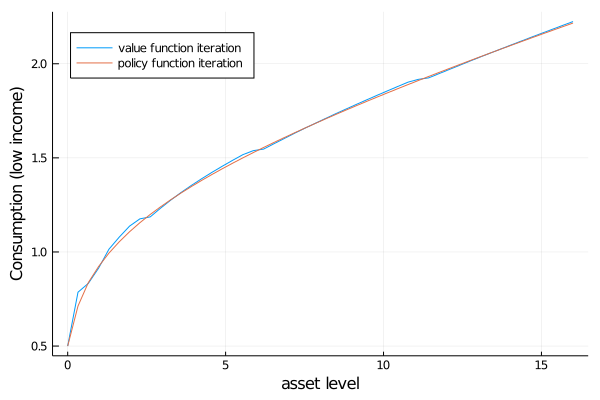

In [8]:
cp = ConsumerProblem()
N = 80

V, c = initialize(cp)
println("Starting value function iteration")
for i in 1:N
    V = T(cp, V)
end
c1 = T(cp, V, ret_policy=true)

V2, c2 = initialize(cp)
println("Starting policy function iteration")
for i in 1:N
    c2 = K(cp, c2)
end

plot(cp.asset_grid, c1[:, 1], label = "value function iteration")
plot!(cp.asset_grid, c2[:, 1], label = "policy function iteration")
plot!(xlabel = "asset level", ylabel = "Consumption (low income)")
plot!(legend = :topleft)

### Exercise 2

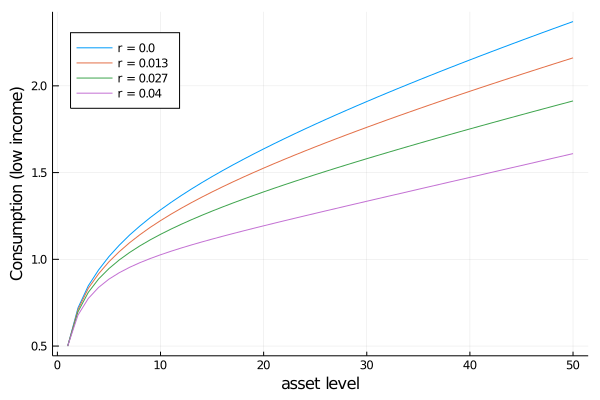

In [9]:
r_vals = range(0, 0.04, length = 4)
traces = []
legends = []

for r_val in r_vals
    cp = ConsumerProblem(r = r_val)
    v_init, c_init = initialize(cp)
    c = compute_fixed_point(x -> K(cp, x),
                            c_init,
                            max_iter = 150,
                            verbose = false)
    traces = push!(traces, c[:, 1])
    legends = push!(legends, "r = $(round(r_val, digits = 3))")
end

plot(traces, label = reshape(legends, 1, length(legends)))
plot!(xlabel = "asset level", ylabel = "Consumption (low income)")
plot!(legend = :topleft)

### Exercise 3

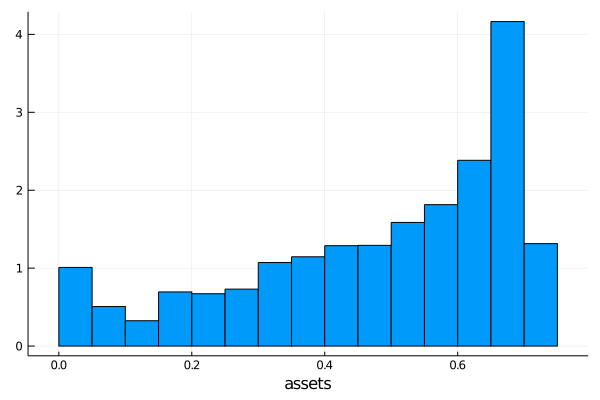

In [10]:
function compute_asset_series(cp, T = 500_000; verbose = false)
    @unpack Π, z_vals, R = cp  # simplify names
    z_idx = 1:length(z_vals)
    v_init, c_init = initialize(cp)
    c = compute_fixed_point(x -> K(cp, x), c_init,
                            max_iter = 150, verbose = false)

    cf = interp(cp.asset_grid, c)

    a = zeros(T + 1)
    z_seq = simulate(MarkovChain(Π), T)
    for t in 1:T
        i_z = z_seq[t]
        a[t+1] = R * a[t] + z_vals[i_z] - cf(a[t], i_z)
    end
    return a
end

cp = ConsumerProblem(r = 0.03, grid_max = 4)
Random.seed!(42) # for reproducibility
a = compute_asset_series(cp)
histogram(a, nbins = 20, leg = false, normed = true, xlabel = "assets")

### Exercise 4

Finished iteration b = 1.0


Finished iteration b = 3.0


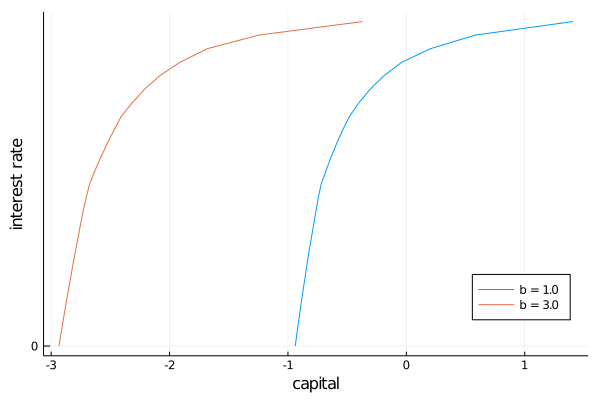

In [11]:
M = 25
r_vals = range(0, 0.04, length = M)

xs = []
ys = []
legends = []
for b in [1.0, 3.0]
    asset_mean = zeros(M)
    for (i, r_val) in enumerate(r_vals)
        cp = ConsumerProblem(r = r_val, b = b)
        the_mean = mean(compute_asset_series(cp, 250_000))
        asset_mean[i] = the_mean
    end
    xs = push!(xs, asset_mean)
    ys = push!(ys, r_vals)
    legends = push!(legends, "b = $b")
    println("Finished iteration b = $b")
end
plot(xs, ys, label = reshape(legends, 1, length(legends)))
plot!(xlabel = "capital", ylabel = "interest rate", yticks = ([0, 0.045]))
plot!(legend = :bottomright)